In [90]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from libs.usage_examples import get_acceptance_indexes
from libs.noise_filter import NoiseFilter

import nltk
nltk.download('all')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\onury\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\onury\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\onury\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\onury\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\onury\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nl

True

In [92]:
LABEL_COL = '2_way_label'

# Import Dataset

In [93]:
data_dir = "./data"
# data_path = os.path.join(data_dir, 'merged_cleaned_data_v26_NoImage.tsv')
# df = pd.read_csv(data_path, sep='\t')
data_path = os.path.join(data_dir, 'merged_cleaned_data_v34_no_photo.csv')
df = pd.read_csv(data_path)

In [94]:
df.describe()

,linked_submission_id,num_comments,score,upvote_ratio,2_way_label,3_way_label,6_way_label
count,0.0,175910.000000,175910.000000,175910.000000,175910.000000,175910.000000,175910.000000
mean,NaN,20.892206,302.834063,0.846546,0.713336,0.560014,0.705435
std,NaN,113.284319,2239.434332,0.121943,0.452204,0.890563,1.240889
min,NaN,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000
25%,NaN,2.000000,4.000000,0.750000,0.000000,0.000000,0.000000
50%,NaN,4.000000,11.000000,0.860000,1.000000,0.000000,0.000000
75%,NaN,11.000000,37.000000,0.950000,1.000000,2.000000,2.000000
max,NaN,6957.000000,104268.000000,1.000000,1.000000,2.000000,5.000000


In [95]:
df.head()

,author,clean_title,hasImage,id,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,comments_orig
0,NaN,escobar a couple of thoughts,False,71lejc,NaN,1,3,fakealbumcovers,Escobar - A Couple of Thoughts,0.81,0,2,1,Thank you for submitting your post to /r/fakealbumcovers. Please make sure you have read [**the rules in the Wiki**](https://www.reddit.com/r/fakealbumcovers/wiki/rules). If you've submitted an album cover or a request please add a link flair to your post. [**You can learn more about link flairs here.**](https://www.reddit.com/r/fakealbumcovers/wiki/linkflairs) *I am a bot and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/fakealbumcovers) if you have any questions or concerns.*
1,running_over_rivers,man found guilty of attempting to murder a corpse,False,3qlikw,NaN,2,26,nottheonion,Man found guilty of attempting to murder a corpse,0.86,1,0,0,Came here just to post this but I'm 5 hours too late.
2,NaN,am i crazy is this a st bernard in runoff candle wax,False,ccx7ru,NaN,11,13,mildlyinteresting,Am I crazy?? Is this a St. Bernard in runoff candle wax?,0.71,1,0,0,It’a a wild sheep.|__|Came here to comment mufasa. Late as always|__|You’re crazy. It’s a lion|__|I’d say it’s a Newfoundlander|__|If that’s a dog it’s a chow chow.|__|That's mufasa|__|That's Mufasa foo|__|Duh. That is obviously a caucasian shepard on a skateboard.
3,NaN,mark zuckerberg,False,8xz41a,NaN,4,831,fakehistoryporn,Mark Zuckerberg (2016),0.99,0,2,2,"The whole time we thought Marl was the computer.|__|What is the episode?|__|At the time people thought this dude was being paranoid. Little did we know...|__|""[Image with added title](https://i.imgur.com/ptbqTVe.png) --- summon me with /u/titletoimagebot | [feedback](https://reddit.com/message/compose/?to=TitleToImageBot&subject=feedback%208xz41a) | [source](https://github.com/gerenook/titletoimagebot/blob/master/titletoimagebot.py) **NEW** custom title! usage: /u/titletoimagebot """"your title here"""""""
4,NaN,a tarantula and my shoe for comparison,False,df4x7j,NaN,7,4,mildlyinteresting,A tarantula(?) and my shoe for comparison,0.83,1,0,0,KILL IT WITH FIRE!|__|They’re as big as your fist (pretend your fist is big) in Arkansas. They’re chill arachnids and just kinda wander around.|__|Looks like one to me! Are you in Colorado by chance? It's tarantula migrating season here so they're meandering through|__|Poor guys missing a leg|__|Nah he was chill|__|K I L L


In [96]:
# Try using first comments only
# df['comments_orig'] = df['comments_orig'].apply(lambda x: x.split('|__|')[0] if isinstance(x, str) else x)
# df['comments'] = df['comments'].apply(lambda x: x.split('|__|')[0] if isinstance(x, str) else x)

# Apply Noise Filter

In [97]:
# Apply Noise Filter

config = {
    'MinLengths': {
        'title': 10,
        # 'comments': 10
        'comments_orig': 10
    },
    'ExcludeImages': True,
    'TextFilters': {
        # 'subreddit': ['news', 'nottheonion'],
    },
}
noise_filter = NoiseFilter(df, config)
df_filtered = noise_filter.apply()
df_filtered

,author,clean_title,hasImage,id,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,comments_orig
2,NaN,am i crazy is this a st bernard in runoff candle wax,False,ccx7ru,NaN,11,13,mildlyinteresting,Am I crazy?? Is this a St. Bernard in runoff candle wax?,0.71,1,0,0,It’a a wild sheep.|__|Came here to comment mufasa. Late as always|__|You’re crazy. It’s a lion|__|I’d say it’s a Newfoundlander|__|If that’s a dog it’s a chow chow.|__|That's mufasa|__|That's Mufasa foo|__|Duh. That is obviously a caucasian shepard on a skateboard.
7,Strawberry_Poptart,cops drug raid in fla retirement community uncovers possible golf cart chopshop,False,8s2x4x,NaN,8,86,nottheonion,Cops: Drug raid in Fla. retirement community uncovers possible golf cart chop-shop,0.93,1,0,0,Bubbles has moved up in the world. https://youtu.be/bD77ln7vZJU|__|Anyone wanna learn more about The Villages? https://www.politico.com/magazine/story/2018/06/18/florida-senior-citizens-vote-election-2018-218758 http://www.tampabay.com/florida-politics/2017/10/05/still-booming-with-retirees-the-villages-gives-trump-gop-edge-in-florida/ http://www.orlandosentinel.com/news/lake/os-villages-democrats-hillarys-america-20160801-story.html https://villages-news.com/trump-voters-will-take/|__|Classic Florida!|__|The Villages you will never find a more wretched hive of scum and villainy|__|False alarm they were just filming John wick chapter 13|__|It's the long awaited sequel to Gone in 60 Seconds Starring geriatric Nic Cage|__|It’s like the South Park Hummel episode. Lol
10,Kuandtity,farher crushes car after catching his daughter in it with a boy,False,4zrzsh,NaN,1,2,nottheonion,Farher crushes car after catching his daughter in it with a boy.,0.75,1,0,0,Thank you for your submission to /r/NotTheOnion! Unfortunately your submission was automatically removed since your submission's title appears to be different from the headline of the article you submitted. Submissions with altered titles are not permitted all titles must be the headline from the article copy-and-pasted. #Please read the information below *before* modmailing us. * Do not add **periods or quotation marks** to the title or change the style of quotation marks used (for example changing single quotes to double quotes). This will cause your submission to be automatically removed as the title has been altered. * Do not use the **suggest title button**. Instead copy-and-paste the article's title *directly* from the link you are submitting. The suggest title button's output is often different from the article's actual title. * Make sure your source doesn't have a **paywall**. Because of the method I use to check titles I've tripped just about every paywall in existence which may cause an occasional incorrect removal. If your source does have a paywall please find an alternative source that is not behind a paywall. You may resubmit with the correct title but remember that our other rules must be followed as well. For more information on our rules check out /r/NotTheOnion/w/NTO101. *I'm a bot and this action was performed automagically.*
13,TheGhostOfTzvika,farm subsidies milking taxpayers as crop prices fall farmers grow subsidies instead,False,2w7x5v,NaN,3,6,usanews,"Farm subsidies: Milking taxpayers -- As crop prices fall, farmers grow subsidies instead",0.66,1,0,0,From the article -- ' THE father of Major Major a character in Catch 22 a novel by Joseph Heller makes a good living not growing alfalfa. “The more alfalfa he did not grow the more money the government gave him and he spent every penny he didn’t earn on new land to increase the amount of alfalfa he did not produce.” Each day Mr Major “sprang out of bed at the crack of noon... just to make certain that the chores would not be done.” ' To this day to be treated as a farmer in America doesn’t necessarily require you to grow any crops. According to the Government Accountability Office between 2007 and 2011 Uncle Sam pai

# Get Acceptance Indexes

In [98]:
def calculate_acceptance_indexes(title, comments, tag=None):
    comment_list = comments.split("|__|")
    results = get_acceptance_indexes(title, comment_list)
    return results

def apply_indexers(df, ref_col, subject_col):
    df_indexed = df.copy()
    df_indexed = pd.concat([df_indexed, df_indexed.apply(lambda x: calculate_acceptance_indexes(x[ref_col], x[subject_col]), axis=1).apply(pd.Series)], axis=1)
    
    return df_indexed


df_orig = apply_indexers(df_filtered, 'title', 'comments_orig')
# df_clean = apply_indexers(df_filtered, 'clean_title', 'comments')
df_orig

,author,clean_title,hasImage,id,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,comments_orig,TextBlobAcceptanceIndexer,NRCAcceptanceIndexer,VADERAcceptanceIndexer
2,NaN,am i crazy is this a st bernard in runoff candle wax,False,ccx7ru,NaN,11,13,mildlyinteresting,Am I crazy?? Is this a St. Bernard in runoff candle wax?,0.71,1,0,0,It’a a wild sheep.|__|Came here to comment mufasa. Late as always|__|You’re crazy. It’s a lion|__|I’d say it’s a Newfoundlander|__|If that’s a dog it’s a chow chow.|__|That's mufasa|__|That's Mufasa foo|__|Duh. That is obviously a caucasian shepard on a skateboard.,0.642969,0.900000,0.854663
7,Strawberry_Poptart,cops drug raid in fla retirement community uncovers possible golf cart chopshop,False,8s2x4x,NaN,8,86,nottheonion,Cops: Drug raid in Fla. retirement community uncovers possible golf cart chop-shop,0.93,1,0,0,Bubbles has moved up in the world. https://youtu.be/bD77ln7vZJU|__|Anyone wanna learn more about The Villages? https://www.politico.com/magazine/story/2018/06/18/florida-senior-citizens-vote-election-2018-218758 http://www.tampabay.com/florida-politics/2017/10/05/still-booming-with-retirees-the-villages-gives-trump-gop-edge-in-florida/ http://www.orlandosentinel.com/news/lake/os-villages-democrats-hillarys-america-20160801-story.html https://villages-news.com/trump-voters-will-take/|__|Classic Florida!|__|The Villages you will never find a more wretched hive of scum and villainy|__|False alarm they were just filming John wick chapter 13|__|It's the long awaited sequel to Gone in 60 Seconds Starring geriatric Nic Cage|__|It’s like the South Park Hummel episode. Lol,0.664435,0.898268,0.915323
10,Kuandtity,farher crushes car after catching his daughter in it with a boy,False,4zrzsh,NaN,1,2,nottheonion,Farher crushes car after catching his daughter in it with a boy.,0.75,1,0,0,Thank you for your submission to /r/NotTheOnion! Unfortunately your submission was automatically removed since your submission's title appears to be different from the headline of the article you submitted. Submissions with altered titles are not permitted all titles must be the headline from the article copy-and-pasted. #Please read the information below *before* modmailing us. * Do not add **periods or quotation marks** to the title or change the style of quotation marks used (for example changing single quotes to double quotes). This will cause your submission to be automatically removed as the title has been altered. * Do not use the **suggest title button**. Instead copy-and-paste the article's title *directly* from the link you are submitting. The suggest title button's output is often different from the article's actual title. * Make sure your source doesn't have a **paywall**. Because of the method I use to check titles I've tripped just about every paywall in existence which may cause an occasional incorrect removal. If your source does have a paywall please find an alternative source that is not behind a paywall. You may resubmit with the correct title but remember that our other rules must be followed as well. For more information on our rules check out /r/NotTheOnion/w/NTO101. *I'm a bot and this action was performed automagically.*,0.697272,0.864815,0.823500
13,TheGhostOfTzvika,farm subsidies milking taxpayers as crop prices fall farmers grow subsidies instead,False,2w7x5v,NaN,3,6,usanews,"Farm subsidies: Milking taxpayers -- As crop prices fall, farmers grow subsidies instead",0.66,1,0,0,From the article -- ' THE father of Major Major a character in Catch 22 a novel by Joseph Heller makes a good living not growing alfalfa. “The more alfalfa he did not grow the more money the government gave him and he spent every penny he didn’t earn on new land to increase the amount of alfalfa he did not produce.” Each day Mr Major “sprang out of bed at the crack of noon... just to make certain that the chores would not be done.” ' To this day to be treated as a far

# Output Results

## Save Datasets for next stage

In [99]:
# Save the data out for the use in the ML Models
df_orig.to_csv('data_with_indexers_applied_to_original_data_4.tsv', index=False, sep='\t')
# df_clean.to_csv('data_with_indexers_applied_to_clean_data.tsv', index=False, sep='\t')

## Evaluation
The remainder is just evaluating the outputs of the Acceptance Indexers 

In [100]:
# dfo_2 = df_orig[['title', 'comments_orig', LABEL_COL, 'TextBlobAcceptanceIndexer', 'NRCAcceptanceIndexer', 'VADERAcceptanceIndexer']]
# dfc_2 = df_clean[['clean_title', 'comments', LABEL_COL, 'TextBlobAcceptanceIndexer', 'NRCAcceptanceIndexer', 'VADERAcceptanceIndexer']]
dfo_2 = df_orig[[LABEL_COL, 'TextBlobAcceptanceIndexer', 'NRCAcceptanceIndexer', 'VADERAcceptanceIndexer']]
# dfc_2 = df_clean[[LABEL_COL, 'TextBlobAcceptanceIndexer', 'NRCAcceptanceIndexer', 'VADERAcceptanceIndexer']]

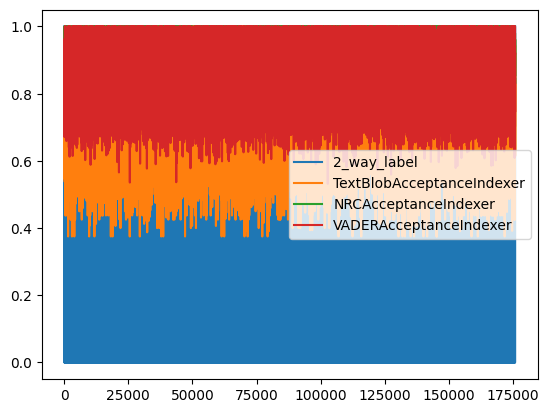

In [101]:
dfo_2.plot(kind='line')
plt.show()

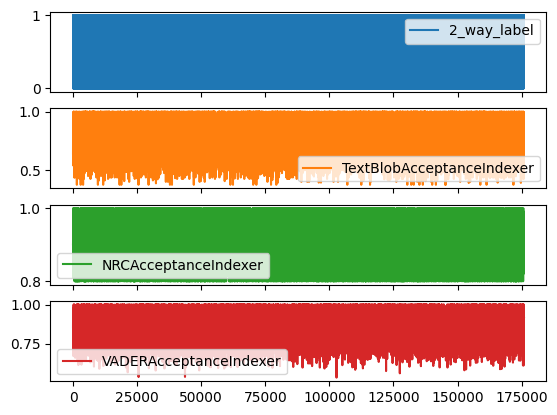

In [102]:
dfo_2.plot(kind='line', subplots=True)
plt.show()

In [103]:
dfo_2.describe()

,2_way_label,TextBlobAcceptanceIndexer,NRCAcceptanceIndexer,VADERAcceptanceIndexer
count,70794.000000,70794.000000,70794.000000,70794.000000
mean,0.767735,0.794239,0.901868,0.861269
std,0.422280,0.097293,0.038024,0.060959
min,0.000000,0.375000,0.800000,0.531669
25%,1.000000,0.738750,0.880235,0.827734
50%,1.000000,0.803524,0.900000,0.867421
75%,1.000000,0.857835,0.924242,0.900431
max,1.000000,1.000000,1.000000,1.000000


array([[<Axes: xlabel='2_way_label', ylabel='2_way_label'>,
        <Axes: xlabel='TextBlobAcceptanceIndexer', ylabel='2_way_label'>,
        <Axes: xlabel='NRCAcceptanceIndexer', ylabel='2_way_label'>,
        <Axes: xlabel='VADERAcceptanceIndexer', ylabel='2_way_label'>],
       [<Axes: xlabel='2_way_label', ylabel='TextBlobAcceptanceIndexer'>,
        <Axes: xlabel='TextBlobAcceptanceIndexer', ylabel='TextBlobAcceptanceIndexer'>,
        <Axes: xlabel='NRCAcceptanceIndexer', ylabel='TextBlobAcceptanceIndexer'>,
        <Axes: xlabel='VADERAcceptanceIndexer', ylabel='TextBlobAcceptanceIndexer'>],
       [<Axes: xlabel='2_way_label', ylabel='NRCAcceptanceIndexer'>,
        <Axes: xlabel='TextBlobAcceptanceIndexer', ylabel='NRCAcceptanceIndexer'>,
        <Axes: xlabel='NRCAcceptanceIndexer', ylabel='NRCAcceptanceIndexer'>,
        <Axes: xlabel='VADERAcceptanceIndexer', ylabel='NRCAcceptanceIndexer'>],
       [<Axes: xlabel='2_way_label', ylabel='VADERAcceptanceIndexer'>,
        <Axe

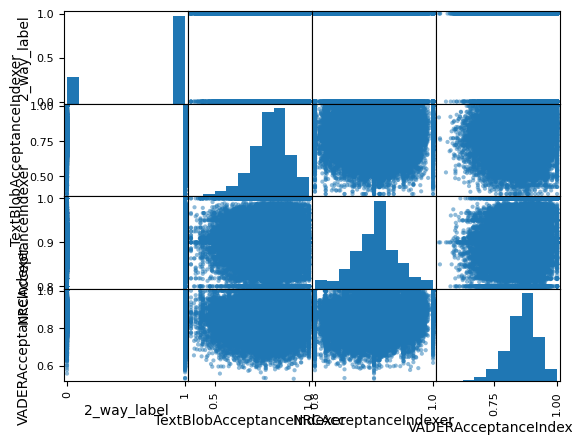

In [104]:
from pandas.plotting import scatter_matrix
scatter_matrix(dfo_2)

In [105]:
dfo_2.describe()

,2_way_label,TextBlobAcceptanceIndexer,NRCAcceptanceIndexer,VADERAcceptanceIndexer
count,70794.000000,70794.000000,70794.000000,70794.000000
mean,0.767735,0.794239,0.901868,0.861269
std,0.422280,0.097293,0.038024,0.060959
min,0.000000,0.375000,0.800000,0.531669
25%,1.000000,0.738750,0.880235,0.827734
50%,1.000000,0.803524,0.900000,0.867421
75%,1.000000,0.857835,0.924242,0.900431
max,1.000000,1.000000,1.000000,1.000000


In [106]:
data_sources = {
    'Orig': dfo_2,
    # 'Clean': dfc_2,
}

Applying thresholds for Orig...


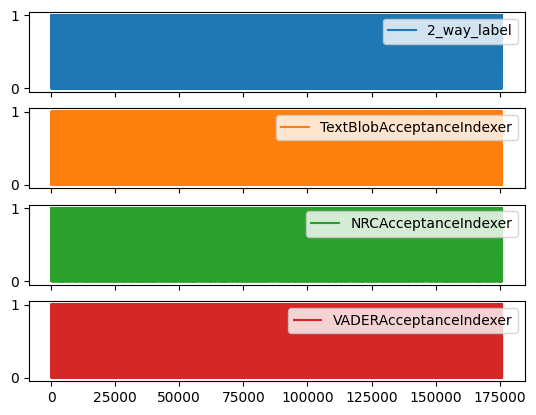

In [107]:
def apply_threshold(df, col, threshold):
    # print(f"Checking {df[col]} > {threshold}")
    df[f"{col}"] = (df[col] > threshold).astype(int)

    return df

indexer_cols = [
    'TextBlobAcceptanceIndexer',
    'NRCAcceptanceIndexer',
    'VADERAcceptanceIndexer',
    # 'CombinedAcceptanceIndexer'
]

for name, df in data_sources.items():
    print(f"Applying thresholds for {name}...")
    df3 = df.copy()
    for col in indexer_cols:
        # df3 = apply_threshold(df3, col, df3[col].mean())

        df3 = apply_threshold(df3, col, (df3[col].min() + (df3[col].max() - df3[col].min()) / 2))


    df3.plot(kind='line', subplots=True)
    plt.show()

Class Balancer to ensure equal number of True and False samples (just for threshold determination)

In [108]:
def balance_classes(df_in, ref_col):
    df = df_in.copy()

    # Count the number of 1s and 0s in the reference column
    num_zeros = df[ref_col].value_counts()[0]
    num_ones = df[ref_col].value_counts()[1]

    # Determine the minimum number of rows to keep
    min_rows = min(num_zeros, num_ones)

    # Filter the results to have an equal number of 0s and 1s
    if num_zeros > num_ones:
        df = pd.concat([
            df.loc[df[ref_col] == 0].sample(min_rows, random_state=42),
            df.loc[df[ref_col] == 1]
        ])
    else:
        df = pd.concat([
            df.loc[df[ref_col] == 0],
            df.loc[df[ref_col] == 1].sample(min_rows, random_state=42)
        ])

    print(f"Equal split leaves {len(df[df[ref_col] == 1])} True values and {len(df[df[ref_col] == 0])} False values")
    
    return df

In [109]:
def validate(df, subject, reference):
    matches = df[subject] == df[reference]
    match_rate = matches.mean() * 100

    print(f"Match Rate between {subject} and {reference}: {match_rate:.2f}%")
    
    return match_rate


for name, df in data_sources.items():
    print(f"Validating results for {name}...")
    df3 = df.copy()
    df3 = balance_classes(df3, LABEL_COL)

    for col in indexer_cols:
        # print(col)
        threshold = (df3[col].min() + (df3[col].max() - df3[col].min()) / 2)
        print(f"Applying threshold of {threshold} for {col}...")
        df3 = apply_threshold(df3, col, threshold)
        validate(df3, col, LABEL_COL)

Validating results for Orig...
Equal split leaves 16443 True values and 16443 False values
Applying threshold of 0.6875 for TextBlobAcceptanceIndexer...
Match Rate between TextBlobAcceptanceIndexer and 2_way_label: 48.28%
Applying threshold of 0.8999999999999999 for NRCAcceptanceIndexer...
Match Rate between NRCAcceptanceIndexer and 2_way_label: 54.15%
Applying threshold of 0.7658343750000001 for VADERAcceptanceIndexer...
Match Rate between VADERAcceptanceIndexer and 2_way_label: 48.05%


Threshold Tuning

In [110]:
import numpy as np
from sklearn.metrics import accuracy_score

def tune_thresholds(df, subject, reference):
    thresholds = np.arange(df[subject].min(), df[subject].max(), 0.01)
    best_threshold = None
    best_accuracy = 0

    for threshold in thresholds:
        df['predicted'] = (df[subject] >= threshold).astype(int)
        # accuracy = (df['predicted'] == df[reference]).mean() * 100
        # accuracy = df['predicted'].corr(df[reference])
        # accuracy = abs(accuracy)
        accuracy = accuracy_score(df['predicted'], df[reference])
        if accuracy > best_accuracy:
            best_threshold = threshold
            best_accuracy = accuracy
        # print(f"Threshold: {threshold}, Accuracy: {accuracy}, Best Threshold: {best_threshold}, Best Accuracy: {best_accuracy}")

    return best_threshold, best_accuracy

for name, df in data_sources.items():
    print(f"Validating results for {name}...")
    df4 = df.copy()
    df4 = balance_classes(df4, LABEL_COL)
    for col in indexer_cols:
        th, acc = tune_thresholds(df4, col, LABEL_COL)
        # print(f"Match Rate between {col} and reference: {acc:.2f}% using a threshold of {th}")
        print(f"Best Match Rate between {col} and reference: {acc:.2f} using a threshold of {th}")

Validating results for Orig...
Equal split leaves 16443 True values and 16443 False values
Best Match Rate between TextBlobAcceptanceIndexer and reference: 0.52 using a threshold of 0.9150000000000005
Best Match Rate between NRCAcceptanceIndexer and reference: 0.54 using a threshold of 0.9
Best Match Rate between VADERAcceptanceIndexer and reference: 0.52 using a threshold of 0.9316687500000004


Normalisation of Acceptance Indexes

In [111]:
# Apply normalisation to the Acceptance Indexes

# Normalise column between 0 and 1
def normalise_column(df, column):
    min_value = df[column].min()
    max_value = df[column].max()
    df[f"{column}_norm"] = (df[column] - min_value) / (max_value - min_value)
    return df

scaled_sources = {}
for name, df in data_sources.items():
    print(f"Normalising {name}...")
    df_scaled = df.copy()
    for col in indexer_cols:
        df_scaled = normalise_column(df_scaled, col)
    
    scaled_sources[name] = df_scaled

Normalising Orig...


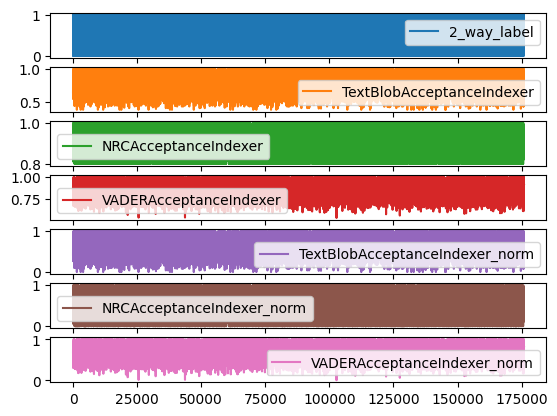

In [112]:
# TODO: Compare indexers using cleaned and uncleaned data
df_scaled.plot(subplots=True)
plt.show()

In [113]:

for name, df in scaled_sources.items():
    print(f"Validating results for {name}...")
    df5 = df.copy()
    df5 = balance_classes(df5, LABEL_COL)
    for col in indexer_cols:
        th, acc = tune_thresholds(df5, f"{col}_norm", LABEL_COL)
        # print(f"Match Rate between {col} and reference: {acc:.2f}% using a threshold of {th}")
        print(f"Best Match Rate between {col} and reference: {acc:.2f} using a threshold of {th:.2f}")

Validating results for Orig...
Equal split leaves 16443 True values and 16443 False values
Best Match Rate between TextBlobAcceptanceIndexer and reference: 0.52 using a threshold of 0.86
Best Match Rate between NRCAcceptanceIndexer and reference: 0.54 using a threshold of 0.50
Best Match Rate between VADERAcceptanceIndexer and reference: 0.52 using a threshold of 0.86
